In [1]:
import terratorch as tt

/shared/marangi/utils/miniconda/miniconda/envs/evocity_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:numexpr.utils:NumExpr defaulting to 12 threads.
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
/shared/marangi/utils/miniconda/miniconda/envs/evocity_env/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [8]:
from terratorch import BACKBONE_REGISTRY
bb_name = "terratorch_prithvi_eo_v2_300"
if bb_name in BACKBONE_REGISTRY:
    backbone = BACKBONE_REGISTRY.build(bb_name, pretrained=True)

INFO:terratorch.models.backbones.prithvi_vit:model_bands not passed. Assuming bands are ordered in the same way as [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_NARROW: 'NIR_NARROW'>, <HLSBands.SWIR_1: 'SWIR_1'>, <HLSBands.SWIR_2: 'SWIR_2'>].Pretrained patch_embed layer may be misaligned with current bands
INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_1 in position 4 of patch embed
INFO:root:Loaded weights for HLSBands.SWIR_2 in position 5 of patch embed


In [10]:
backbone

PrithviViT(
  (patch_embed): PatchEmbed(
    (proj): Conv3d(6, 1024, kernel_size=(1, 16, 16), stride=(1, 16, 16))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-23): 24 x Block(
      (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (fc2): Linear(in_features=4096, out_features=

In [14]:
import terratorch as tt
from terratorch.datamodules import GenericNonGeoClassificationDataModule
import rasterio as rio
from rasterio.errors import NotGeoreferencedWarning
import warnings
warnings.filterwarnings("ignore", category=NotGeoreferencedWarning)

TRAIN_PATH = "/shared/marangi/projects/EVOCITY/building_extraction/data/OpenWUSU512/train"
TEST_PATH = "/shared/marangi/projects/EVOCITY/building_extraction/data/OpenWUSU512/test"

In [107]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import json
from matplotlib.colors import ListedColormap, BoundaryNorm

def class_mapping_to_cmap_norm(class_mapping, cmap='tab20'):
    """
    Crea una colormap e una normalizzazione per la visualizzazione di maschere di segmentazione,
    garantendo coerenza tra colori, classi e legenda, a partire da un mapping {class_name: class_id}.

    Args:
        class_mapping (dict): Dizionario {nome_classe: valore_classe} (es. {"Road": 1, ...}).
        cmap (str): Nome della colormap matplotlib da usare (default: 'tab20').

    Returns:
        cmap (ListedColormap): Colormap customizzata da usare in plt.imshow.
        norm (BoundaryNorm): Normalizzazione per mappare i valori delle classi ai colori.
        class_names (list): Lista ordinata dei nomi delle classi.
        colors (list): Lista dei colori associati alle classi (stesso ordine di class_names).

    Note:
        - La funzione ordina le classi in base al valore numerico (class_id).
        - La colormap risultante è consistente: stesso colore per stessa classe in tutte le immagini.
        - Utile per plt.imshow(mask, cmap=cmap, norm=norm) e per generare legende custom.
    """
    class_items = sorted(class_mapping.items(), key=lambda x: int(x[1]))
    class_names = [item[0] for item in class_items]
    class_values = [int(item[1]) for item in class_items]
    n_classes = len(class_names)
    base_colors = plt.get_cmap('tab20').colors
    colors = [base_colors[i%len(base_colors)] for i in range(n_classes)]
    value_to_color = {v : colors[i] for i, v in enumerate(sorted(class_values))}
    cmap = ListedColormap([value_to_color[v] for v in sorted(class_values)])
    norm = BoundaryNorm(class_values + [max(class_values)+1], n_classes)
    return cmap, norm, class_names, colors

def plot_legend(class_names, colors):
    """
    Crea e visualizza una legenda custom per segmentazione semantica,
    associando ogni colore al nome della classe.

    Args:
        class_names (list): Lista ordinata dei nomi delle classi.
        colors (list): Lista dei colori associati alle classi (stesso ordine di class_names).

    Note:
        - La legenda mostra tutte le classi, anche se non presenti nella maschera.
        - Da usare dopo aver visualizzato la maschera con plt.imshow(...).
    """
    patches = [mpatches.Patch(color=colors[i], label=f"{i}: {class_names[i]}") for i in range(len(class_names))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

def show_img_mask(img_path, mask_path, class_mapping):
    """
    Visualizza affiancati un'immagine RGB e la sua maschera di segmentazione,
    utilizzando una colormap e una legenda coerenti con il mapping delle classi.

    Args:
        img_path (str): Percorso all'immagine RGB (GeoTIFF).
        mask_path (str): Percorso alla maschera di segmentazione (GeoTIFF).
        class_mapping (dict): Mapping {nome_classe: valore_classe}.

    Note:
        - I colori della maschera e della legenda sono sempre consistenti tra immagini diverse.
        - La legenda mostra tutte le classi, anche se non presenti nella maschera visualizzata.
        - Richiede che la funzione `class_mapping_to_cmap_norm` e `plot_legend` siano definite.
    """
    with rio.open(img_path) as img:
        with rio.open(mask_path) as mask:
            print(f"Image shape: {img.shape}, Mask shape: {mask.shape}")
            mask_array = mask.read(1)
            unique_vals = np.unique(mask_array)
            print(f"Unique mask_values: {unique_vals}")

            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            # Visualizza img
            axes[0].imshow(img.read([1,2,3]).transpose(1,2,0))
            axes[0].set_title(img_path.split('/')[-1] + " Image")
            axes[0].axis('off')
            # Visualizza mask
            cmap, norm, class_names, colors = class_mapping_to_cmap_norm(class_mapping)
            axes[1].imshow(mask_array, cmap=cmap, norm=norm)
            axes[1].set_title(mask_path.split('/')[-1] + " Mask")
            axes[1].axis('off')
            plot_legend(class_names, colors)
            plt.tight_layout()
            plt.show()

Image shape: (512, 512), Mask shape: (512, 512)
Unique mask_values: [0 1 2 3]


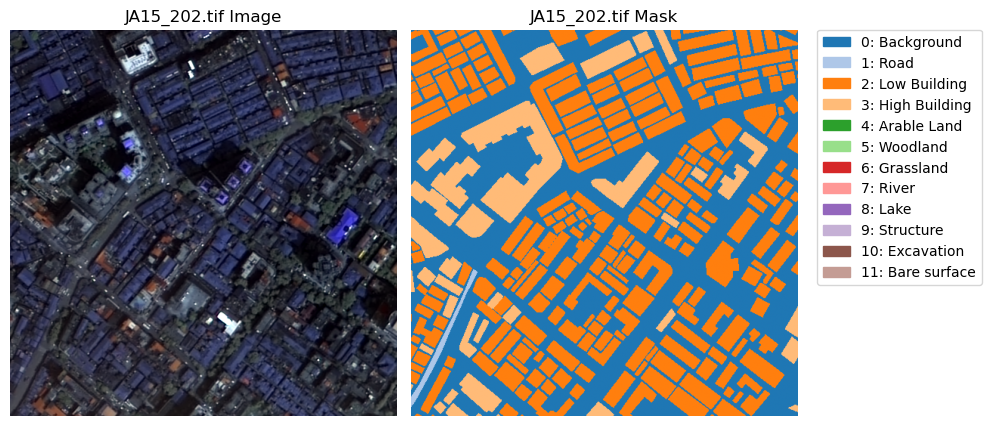

In [117]:
img_idx = 202
IMG_PATH = f"{TRAIN_PATH}/JA/imgs/JA15_{img_idx}.tif"
MASK_PATH = f"{TRAIN_PATH}/JA/class/JA15_{img_idx}.tif"
with open("/shared/marangi/projects/EVOCITY/building_extraction/data/OpenWUSU512/class_mapping.json") as f:
    class_mapping = json.load(f)

show_img_mask(IMG_PATH, MASK_PATH, class_mapping)

Image shape: (512, 512), Mask shape: (512, 512)
Unique mask_values: [ 0  1  2  3  6  7  9 10 11]


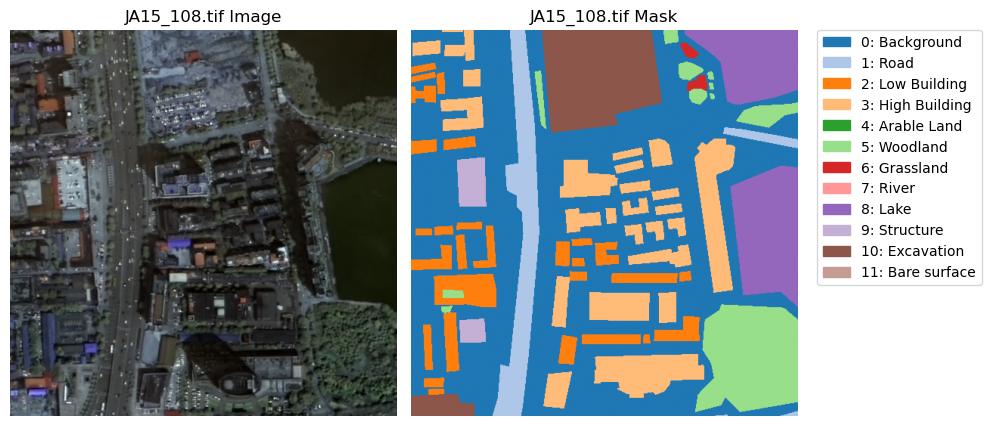

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import json

def class_mapping_to_cmap_norm(class_mapping, cmap='tab20'):
    """
    Crea una colormap e una normalizzazione per la visualizzazione di maschere di segmentazione,
    garantendo coerenza tra colori, classi e legenda, a partire da un mapping {class_name: class_id}.

    Args:
        class_mapping (dict): Dizionario {nome_classe: valore_classe} (es. {"Road": 1, ...}).
        cmap (str): Nome della colormap matplotlib da usare (default: 'tab20').

    Returns:
        cmap (ListedColormap): Colormap customizzata da usare in plt.imshow.
        norm (BoundaryNorm): Normalizzazione per mappare i valori delle classi ai colori.
        class_names (list): Lista ordinata dei nomi delle classi.
        colors (list): Lista dei colori associati alle classi (stesso ordine di class_names).

    Note:
        - La funzione ordina le classi in base al valore numerico (class_id).
        - La colormap risultante è consistente: stesso colore per stessa classe in tutte le immagini.
        - Utile per plt.imshow(mask, cmap=cmap, norm=norm) e per generare legende custom.
    """
    from matplotlib.colors import ListedColormap, BoundaryNorm
    class_items = sorted(class_mapping.items(), key=lambda x: int(x[1]))
    class_names = [item[0] for item in class_items]
    class_values = [int(item[1]) for item in class_items]
    n_classes = len(class_names)
    base_colors = plt.get_cmap('tab20').colors
    colors = [base_colors[i%len(base_colors)] for i in range(n_classes)]
    value_to_color = {v : colors[i] for i, v in enumerate(sorted(class_values))}
    cmap = ListedColormap([value_to_color[v] for v in sorted(class_values)])
    norm = BoundaryNorm(class_values + [max(class_values)+1], n_classes)
    return cmap, norm, class_names, colors

def plot_legend(class_names, colors):
    """
    Crea e visualizza una legenda custom per segmentazione semantica,
    associando ogni colore al nome della classe.

    Args:
        class_names (list): Lista ordinata dei nomi delle classi.
        colors (list): Lista dei colori associati alle classi (stesso ordine di class_names).

    Note:
        - La legenda mostra tutte le classi, anche se non presenti nella maschera.
        - Da usare dopo aver visualizzato la maschera con plt.imshow(...).
    """
    patches = [mpatches.Patch(color=colors[i], label=f"{i}: {class_names[i]}") for i in range(len(class_names))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

def show_img_mask(img_path, mask_path, class_mapping):
    """
    Visualizza affiancati un'immagine RGB e la sua maschera di segmentazione,
    utilizzando una colormap e una legenda coerenti con il mapping delle classi.

    Args:
        img_path (str): Percorso all'immagine RGB (GeoTIFF).
        mask_path (str): Percorso alla maschera di segmentazione (GeoTIFF).
        class_mapping (dict): Mapping {nome_classe: valore_classe}.

    Note:
        - I colori della maschera e della legenda sono sempre consistenti tra immagini diverse.
        - La legenda mostra tutte le classi, anche se non presenti nella maschera visualizzata.
        - Richiede che la funzione `class_mapping_to_cmap_norm` e `plot_legend` siano definite.
    """
    with rio.open(img_path) as img:
        with rio.open(mask_path) as mask:
            print(f"Image shape: {img.shape}, Mask shape: {mask.shape}")
            mask_array = mask.read(1)
            unique_vals = np.unique(mask_array)
            print(f"Unique mask_values: {unique_vals}")

            fig, axes = plt.subplots(1, 2, figsize=(10, 5))
            # Visualizza img
            axes[0].imshow(img.read([1,2,3]).transpose(1,2,0))
            axes[0].set_title(img_path.split('/')[-1] + " Image")
            axes[0].axis('off')
            # Visualizza mask
            cmap, norm, class_names, colors = class_mapping_to_cmap_norm(class_mapping)
            axes[1].imshow(mask_array, cmap=cmap, norm=norm)
            axes[1].set_title(mask_path.split('/')[-1] + " Mask")
            axes[1].axis('off')
            plot_legend(class_names, colors)
            plt.tight_layout()
            plt.show()

img_idx = 108
IMG_PATH = f"{TRAIN_PATH}/JA/imgs/JA15_{img_idx}.tif"
MASK_PATH = f"{TRAIN_PATH}/JA/class/JA15_{img_idx}.tif"
with open("/shared/marangi/projects/EVOCITY/building_extraction/data/OpenWUSU512/class_mapping.json") as f:
    class_mapping = json.load(f)

show_img_mask(IMG_PATH, MASK_PATH, class_mapping)

In [ ]:
import re

def extract_aoi(filename):
    match = re.search(r'_(\d+)\.tif$', filename)
    if match:
        return match.group(1)
    return None


['JA', 'HS']

In [131]:
import os
for city in os.listdir("/shared/marangi/projects/EVOCITY/building_extraction/data/OpenWUSU512/test"):
    print(city)
    for folder in os.listdir(f"/shared/marangi/projects/EVOCITY/building_extraction/data/OpenWUSU512/test/{city}"):
        print(" ", folder) 
        if folder == "change":
            for cd_type in os.listdir(f"/shared/marangi/projects/EVOCITY/building_extraction/data/OpenWUSU512/test/{city}/{folder}"):
                print(os.listdir(f"/shared/marangi/projects/EVOCITY/building_extraction/data/OpenWUSU512/test/{city}/{folder}/{cd_type}"))
        for file in os.listdir(f"/shared/marangi/projects/EVOCITY/building_extraction/data/OpenWUSU512/test/{city}/{folder}"):
            print(file)

JA
  change
['JA1618_243.tif', 'JA1618_151.tif', 'JA1516_190.tif', 'JA1618_130.tif', 'JA1618_180.tif', 'JA1618_69.tif', 'JA1516_259.tif', 'JA1618_213.tif', 'JA1618_193.tif', 'JA1516_50.tif', 'JA1516_11.tif', 'JA1516_100.tif', 'JA1618_119.tif', 'JA1618_72.tif', 'JA1516_157.tif', 'JA1618_54.tif', 'JA1516_62.tif', 'JA1516_72.tif', 'JA1618_109.tif', 'JA1516_269.tif', 'JA1516_253.tif', 'JA1618_24.tif', 'JA1516_191.tif', 'JA1516_186.tif', 'JA1618_38.tif', 'JA1516_218.tif', 'JA1618_99.tif', 'JA1618_21.tif', 'JA1618_45.tif', 'JA1618_171.tif', 'JA1618_106.tif', 'JA1516_246.tif', 'JA1618_26.tif', 'JA1516_129.tif', 'JA1516_221.tif', 'JA1618_132.tif', 'JA1618_57.tif', 'JA1618_135.tif', 'JA1618_63.tif', 'JA1618_202.tif', 'JA1516_5.tif', 'JA1618_20.tif', 'JA1618_205.tif', 'JA1618_215.tif', 'JA1516_112.tif', 'JA1618_228.tif', 'JA1516_32.tif', 'JA1618_173.tif', 'JA1516_210.tif', 'JA1516_134.tif', 'JA1618_207.tif', 'JA1516_162.tif', 'JA1516_202.tif', 'JA1516_51.tif', 'JA1618_225.tif', 'JA1516_250.tif',

In [141]:
from glob import glob
TRAIN_PATH = "/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/train"
VAL_PATH = "/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/val"
TEST_PATH = "/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/test"
train_image_paths = glob(f"{TRAIN_PATH}/**/imgs/*.tif", recursive=True)
train_mask_paths = glob(f"{TRAIN_PATH}/**/class/*.tif", recursive=True)
val_image_paths = glob(f"{VAL_PATH}/**/imgs/*.tif", recursive=True)
val_mask_paths = glob(f"{VAL_PATH}/**/class/*.tif", recursive=True)
test_image_paths = glob(f"{TEST_PATH}/**/imgs/*.tif", recursive=True)
test_mask_paths = glob(f"{TEST_PATH}/**/class/*.tif", recursive=True)
train_image_paths.sort()
train_mask_paths.sort()
val_image_paths.sort()
val_mask_paths.sort()
test_image_paths.sort()
test_mask_paths.sort()


In [156]:
idx = 5
print(f"Train Image: {train_image_paths[idx].split('/')[-1]}, Train Mask: {train_mask_paths[idx].split('/')[-1]}")
print(f"Val Image: {val_image_paths[idx].split('/')[-1]}, Val Mask: {val_mask_paths[idx].split('/')[-1]}")
print(f"Test Image: {test_image_paths[idx].split('/')[-1]}, Test Mask: {test_mask_paths[idx].split('/')[-1]}")

Train Image: HS15_102.tif, Train Mask: HS15_102.tif
Val Image: HS15_110.tif, Val Mask: HS15_110.tif
Test Image: HS15_102.tif, Test Mask: HS15_102.tif


In [157]:
train_mask_paths

['/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/train/HS/class/HS15_0.tif',
 '/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/train/HS/class/HS15_1.tif',
 '/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/train/HS/class/HS15_10.tif',
 '/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/train/HS/class/HS15_100.tif',
 '/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/train/HS/class/HS15_101.tif',
 '/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/train/HS/class/HS15_102.tif',
 '/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/train/HS/class/HS15_103.tif',
 '/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/train/HS/class/HS15_104.tif',
 '/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/train/HS/class/HS15_105.tif',
 '/shared/marangi/projects/EVOCIT

In [10]:
from dataset import SSDataset
from glob import glob
from torch.utils.data import DataLoader
TRAIN_PATH = "/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/train"
VAL_PATH = "/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/val"
TEST_PATH = "/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/test"
train_image_paths = glob(f"{TRAIN_PATH}/**/imgs/*.tif", recursive=True)
train_mask_paths = glob(f"{TRAIN_PATH}/**/class/*.tif", recursive=True)
val_image_paths = glob(f"{VAL_PATH}/**/imgs/*.tif", recursive=True)
val_mask_paths = glob(f"{VAL_PATH}/**/class/*.tif", recursive=True)
test_image_paths = glob(f"{TEST_PATH}/**/imgs/*.tif", recursive=True)
test_mask_paths = glob(f"{TEST_PATH}/**/class/*.tif", recursive=True)
train_image_paths.sort()
train_mask_paths.sort()
val_image_paths.sort()
val_mask_paths.sort()
test_image_paths.sort()
test_mask_paths.sort()

train_set = SSDataset(train_image_paths, train_mask_paths)
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=4)

In [11]:
image, mask = next(iter(train_loader))
print(image.shape, mask.shape)

/shared/marangi/utils/miniconda/miniconda/envs/evocity_env/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/shared/marangi/utils/miniconda/miniconda/envs/evocity_env/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/shared/marangi/utils/miniconda/miniconda/envs/evocity_env/lib/python3.12/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/shared/marangi/utils/miniconda/miniconda/envs/evocity_env/lib/python3.12/site-packages/rasterio/__init__.py:356: N

torch.Size([16, 4, 512, 512]) torch.Size([16, 512, 512])


Valori unici nella maschera originale: [ 0  1  2  3  6  7 10 11]
Valori unici nella maschera mappata:  tensor([ 0,  1,  2,  3,  5,  6,  9, 10])


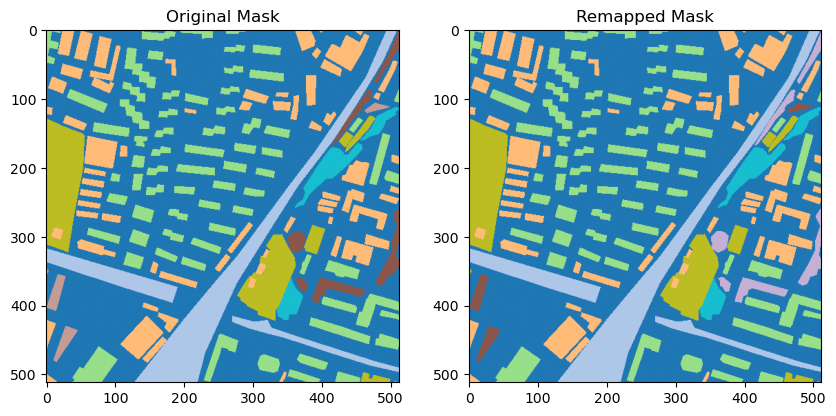

In [26]:
import torch
import json
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np

def remap_mask(mask):
    with open("/shared/marangi/projects/EVOCITY/building_extraction/data/OpenWUSU512/class_mapping.json") as f:
        original_class_mapping = json.load(f)
    sorted_original_classes = sorted(original_class_mapping.values())
    # Creo il tensore che mappa il vecchio indice al nuovo, usando 255 come valore temporaneo
    remapping_tensor = torch.full((len(sorted_original_classes) + 1,), 255, dtype=torch.long)
    for new_idx, old_idx in enumerate(sorted_original_classes):
        remapping_tensor[old_idx] = new_idx
    return remapping_tensor[mask]

idx = 1
year = 18
mask_path = f"/shared/marangi/projects/EVOCITY/building_extraction/data/WUSU_preprocessed/train/HS/class/HS{year}_{idx}.tif"
with rio.open(mask_path) as mask_file:
    original_mask_array = mask_file.read(1)
    mask_torch = torch.from_numpy(original_mask_array.astype('int64'))
    remapped_mask_torch = remap_mask(mask_torch)
    print(f"Valori unici nella maschera originale: {np.unique(original_mask_array)}")
    print(f"Valori unici nella maschera mappata:  {torch.unique(remapped_mask_torch)}")
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_mask_array, cmap='tab20', vmin=0, vmax=12)
    ax[0].set_title("Original Mask")
    ax[1].imshow(remapped_mask_torch, cmap='tab20', vmin=0, vmax=11)
    ax[1].set_title("Remapped Mask")
    plt.show()


In [2]:
from terratorch import BACKBONE_REGISTRY, DECODER_REGISTRY
print(BACKBONE_REGISTRY.keys())
print(DECODER_REGISTRY.keys())

/shared/marangi/utils/miniconda/miniconda/envs/evocity_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:numexpr.utils:NumExpr defaulting to 12 threads.
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
/shared/marangi/utils/miniconda/miniconda/envs/evocity_env/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


odict_keys(['terratorch', 'timm'])
odict_keys(['terratorch', 'smp'])


In [8]:
for bb_name in BACKBONE_REGISTRY['terratorch']:
    print(bb_name)

dofa_small_patch16_224
dofa_base_patch16_224
dofa_large_patch16_224
prithvi_eo_tiny
prithvi_eo_v1_100
prithvi_eo_v2_tiny_tl
prithvi_eo_v2_100_tl
prithvi_eo_v2_300
prithvi_eo_v2_600
prithvi_eo_v2_300_tl
prithvi_eo_v2_600_tl
terramind_v1_base
terramind_v1_base_tim
terramind_v01_base
terramind_v01_base_tim
terramind_v1_large
terramind_v1_large_tim
terramind_v1_tiny
terramind_v1_tiny_tim
terramind_v1_small
terramind_v1_small_tim
terramind_v1_tokenizer_s2l2a
terramind_v1_tokenizer_s1rtc
terramind_v1_tokenizer_s1grd
terramind_v1_tokenizer_dem
terramind_v1_tokenizer_lulc
terramind_v1_tokenizer_ndvi
ssl4eol_resnet18_landsat_tm_toa_moco
ssl4eol_resnet18_landsat_tm_toa_simclr
ssl4eol_resnet18_landsat_etm_toa_moco
ssl4eol_resnet18_landsat_etm_toa_simclr
ssl4eol_resnet18_landsat_etm_sr_moco
ssl4eol_resnet18_landsat_etm_sr_simclr
ssl4eol_resnet18_landsat_oli_tirs_toa_moco
ssl4eol_resnet18_landsat_oli_tirs_toa_simclr
ssl4eol_resnet18_landsat_oli_sr_moco
ssl4eol_resnet18_landsat_oli_sr_simclr
ssl4eos

In [4]:
for bb_name in BACKBONE_REGISTRY['timm']:
    print(bb_name)

aimv2_1b_patch14_224
aimv2_1b_patch14_336
aimv2_1b_patch14_448
aimv2_3b_patch14_224
aimv2_3b_patch14_336
aimv2_3b_patch14_448
aimv2_huge_patch14_224
aimv2_huge_patch14_336
aimv2_huge_patch14_448
aimv2_large_patch14_224
aimv2_large_patch14_336
aimv2_large_patch14_448
bat_resnext26ts
beit3_base_patch16_224
beit3_giant_patch14_224
beit3_giant_patch14_336
beit3_large_patch16_224
beit_base_patch16_224
beit_base_patch16_384
beit_large_patch16_224
beit_large_patch16_384
beit_large_patch16_512
beitv2_base_patch16_224
beitv2_large_patch16_224
botnet26t_256
botnet50ts_256
caformer_b36
caformer_m36
caformer_s18
caformer_s36
cait_m36_384
cait_m48_448
cait_s24_224
cait_s24_384
cait_s36_384
cait_xs24_384
cait_xxs24_224
cait_xxs24_384
cait_xxs36_224
cait_xxs36_384
clay_v1_base
coat_lite_medium
coat_lite_medium_384
coat_lite_mini
coat_lite_small
coat_lite_tiny
coat_mini
coat_small
coat_tiny
coatnet_0_224
coatnet_0_rw_224
coatnet_1_224
coatnet_1_rw_224
coatnet_2_224
coatnet_2_rw_224
coatnet_3_224
coatn

In [11]:
for dc_name in DECODER_REGISTRY['terratorch']:
    print(dc_name)

ASPPModule
ASPPHead
ASPPSegmentationHead
ASPPRegressionHead
FCNDecoder
IdentityDecoder
LinearDecoder
MLPDecoder
SatMAEHead
UNetDecoder
UperNetDecoder


In [12]:
for dc_name in DECODER_REGISTRY['smp']:
    print(dc_name)

PAN
Unet
Linknet
DeepLabV3Plus
FPN
PSPNet
Segformer
UPerNet
MAnet
DeepLabV3
UnetPlusPlus
